# Bicycle Accidents x Geo Data x Strava Exposure Merge

<small>

## Prerequisites for Latex-friendly Figures

This notebook uses **tueplots** with LaTeX rendering for visualizations. 

### Required Setup:

**1. Install TinyTeX (LaTeX distribution)**
```bash
# Option A: Via R (if you have R installed)
Rscript -e "tinytex::install_tinytex()"

# Option B: Direct installer (macOS)
curl -sL "https://yihui.org/tinytex/install-bin-unix.sh" | sh
```

**2. Install Required LaTeX Packages**
```bash
tlmgr update --self
tlmgr install type1cm cm-super underscore dvipng
```

**3. Add TinyTeX to PATH**
```bash
echo 'export PATH="$HOME/Library/TinyTeX/bin/universal-darwin:$PATH"' >> ~/.zshrc
source ~/.zshrc
```

**4. Verify Installation**
```bash
which latex && which dvipng
```

</small>

In [3]:
import sys
from pathlib import Path

# Ensure project root is importable when running from notebooks/
_project_root = Path.cwd().resolve()
if not (_project_root / "src").exists() and (_project_root.parent / "src").exists():
    _project_root = _project_root.parent
sys.path.insert(0, str(_project_root))

import os
os.environ['PATH'] = f"{os.path.expanduser('~/Library/TinyTeX/bin/universal-darwin')}:{os.environ['PATH']}"

import datetime as dt
import gc
import importlib

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Module imports
import src.accidents as accidents
import src.segments as segments
import src.strava_exposure as strava_exposure
import src.panels as panels
import src.nodes as nodes

# Reload project modules to get latest changes
for _m in (accidents, segments, strava_exposure, panels, nodes):
    importlib.reload(_m)

from src.accidents import (
    ACCIDENT_COLUMNS_EN,
    assign_accidents_to_nearest_segment,
    load_accidents_raw,
    prepare_accidents_bike_berlin,
    add_temporal_features,
    plot_accident_quality_overview,
)
from src.segments import load_segment_geometry, plot_segment_quality_overview
from src.strava_exposure import (
    build_exposure_panel_segment_year_month,
    categorize_strava_features,
    column_stability_summary,
    compute_segment_filter_impact,
    filter_zero_traffic_years,
    get_daily_outlier_days,
    load_strava_berlin_data,
    plot_strava_quality_overview,
)
from src.panels import (
    aggregate_accidents_segment_year_month_rich,
    merge_exposure_and_accidents,
    plot_merged_panel_quality_overview,
    sanity_check_merge,
)
from src.nodes import (
    assign_accidents_to_nearest_crossing,
    build_node_exposure_panel_from_segments,
    build_nodes_from_segment_endpoints,
    cluster_nodes_snap_grid,
    print_node_exposure_quality_summary,
    select_crossings_by_degree,
)

# Configuration constants
DATA_DIR = _project_root / "data"
MERGED_DIR = DATA_DIR / "panel"
CANONICAL_CRS = "EPSG:32633"
MAX_DISTANCE_M = 10
MAX_DISTANCE_M_NEREAST_CROSSING = 20
NODE_SNAP_TOLERANCE_M = 2
CROSSING_MIN_DEGREE = 3


def save_panel(df, filename, crs=None, format='parquet'):
    """Save dataframe to parquet or CSV in merged directory.
    
    Parameters
    ----------
    df : DataFrame
        Data to save
    filename : str
        Output filename
    crs : str, optional
        CRS for GeoDataFrame, by default None
    format : str, optional
        Output format ('csv' or 'parquet'), by default 'parquet'
    """
    MERGED_DIR.mkdir(parents=True, exist_ok=True)
    
    # Adjust filename extension based on format
    if format == 'csv':
        filename = filename.replace('.parquet', '.csv')
    elif format == 'parquet':
        filename = filename.replace('.csv', '.parquet')
    
    out_path = MERGED_DIR / filename
    
    if crs is not None:
        df = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
    
    if format == 'csv':
        df.to_csv(out_path, index=False)
    else:  # parquet

        df.to_parquet(out_path, index=False, engine='pyarrow', coerce_timestamps='ms'),
        return out_path

    print(f"Saved: {out_path}")

AttributeError: partially initialized module 'pandas' from '/Users/edwardeichhorn/Desktop/Master QDS/3. Semester/Data Literacy/data_literacy/.venv/lib/python3.14/site-packages/pandas/__init__.py' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

## Raw Datasets

### 1. Accident Data
- **Source**: [Destatis Unfallatlas](https://unfallatlas.statistikportal.de/)
- **Time Coverage**: 2019-2023 (as we have Strava exposure data for relative years only)
- **Files**: CSV files from `data/accidents/` directory (Unfallorte_201[9-2023]_LinRef.csv)
- **Description**: Personal injury bicycle accidents in Berlin, Germany. The Accident Atlas contains accidents with personal injury only; material-damage-only accidents are excluded.
- **Key Fields**: Accident location coordinates, date, severity, accident type, street and other conditions
- **Limitation**: In accidents data we don't have specific datetime of accidents, only month, weekday and hour

### 2. Strava Exposure Data
- **Source**: [Urban Traffic Volume Dataset – Berlin (Strava), Zenodo](https://zenodo.org/records/15332147)
- **License**: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- **File**: `data/strava/berlin_data.parquet` (460.3 MB)
- **Time Coverage**: 2019-2023 (daily bicycle traffic volumes)
- **Description**: Daily bicycle traffic volumes aggregated from publicly shared Strava user data. Strava volumes are rounded aggregates of bike trips, with extreme outliers filtered per segment to focus on typical traffic conditions.
- **Auxiliary Features**: Built environment (speed limits, road types, lane counts), Points of Interest (shops, schools, transit stops), network connectivity metrics (degree, betweenness), temporal indicators (weekday, holidays, month), weather data (sunshine, precipitation, temperature), socioeconomic indicators, proxy motorized traffic metrics
- **Key Fields**: Segment identifiers, temporal aggregation (year/month), trip counts, activity metrics, environmental and infrastructure features

### 3. Road Network Geometry
- **Source**: [Urban Traffic Volume Dataset – Berlin (Strava), Zenodo](https://zenodo.org/records/15332147)
- **License**: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- **File**: `data/strava/berlin_graph_geometry.parquet` (1.6 MB)
- **CRS**: EPSG:32633 (UTM Zone 33N)
- **Description**: Geospatial representation of Berlin's road network at street-segment level with geometric attributes
- **Key Fields**: Segment IDs, LineString geometries, segment properties

### Citation
For Strava Berlin dataset:
> Kaiser, S. K., Rodrigues, F., Azevedo Lima, C., & Kaack, L.H. (2025). Spatio-Temporal Graph Neural Network for Urban Spaces: Interpolating Citywide Traffic Volume. [published on arXiv].

In [14]:
accidents_raw = load_accidents_raw(csv_dir=DATA_DIR / "accidents")
segments_geometry_raw = load_segment_geometry(parquet_path = DATA_DIR / "strava" / "berlin_graph_geometry.parquet", canonical_crs=CANONICAL_CRS)
strava_berlin_data_raw = load_strava_berlin_data(parquet_path=DATA_DIR / "strava" / "berlin_data.parquet")

Reading berlin_graph_geometry.parquet locally from /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/strava/berlin_graph_geometry.parquet
Reading berlin_data.parquet locally from /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/strava/berlin_data.parquet


# Data preprocessing & Data Quality Check

## Accidents data

In [20]:
accidents_bike_berlin = prepare_accidents_bike_berlin(accidents_raw, column_map=ACCIDENT_COLUMNS_EN)
# Add temporal features (weekday_type and time_of_day)
accidents_bike_berlin = add_temporal_features(accidents_bike_berlin)

print("Raw accidents shape:", accidents_raw.shape)
# 2 additional columns (28->30): 'weekday_type', 'time_of_day'
pct_remaining = (accidents_bike_berlin.shape[0] / accidents_raw.shape[0]) * 100
print(f"Filtered to bicycle accidents in Berlin (bike type + Berlin bounds) -> shape: {accidents_bike_berlin.shape} ({pct_remaining:.1f}% of original)")

# Free big raw dataframe early to keep memory low for Strava aggregatio
# del accidents_raw
# gc.collect()

Raw accidents shape: (1270730, 28)
Filtered to bicycle accidents in Berlin (bike type + Berlin bounds) -> shape: (23537, 30) (1.9% of original)


/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/accidents.py:491: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.94, hspace=0.4, wspace=0.3)


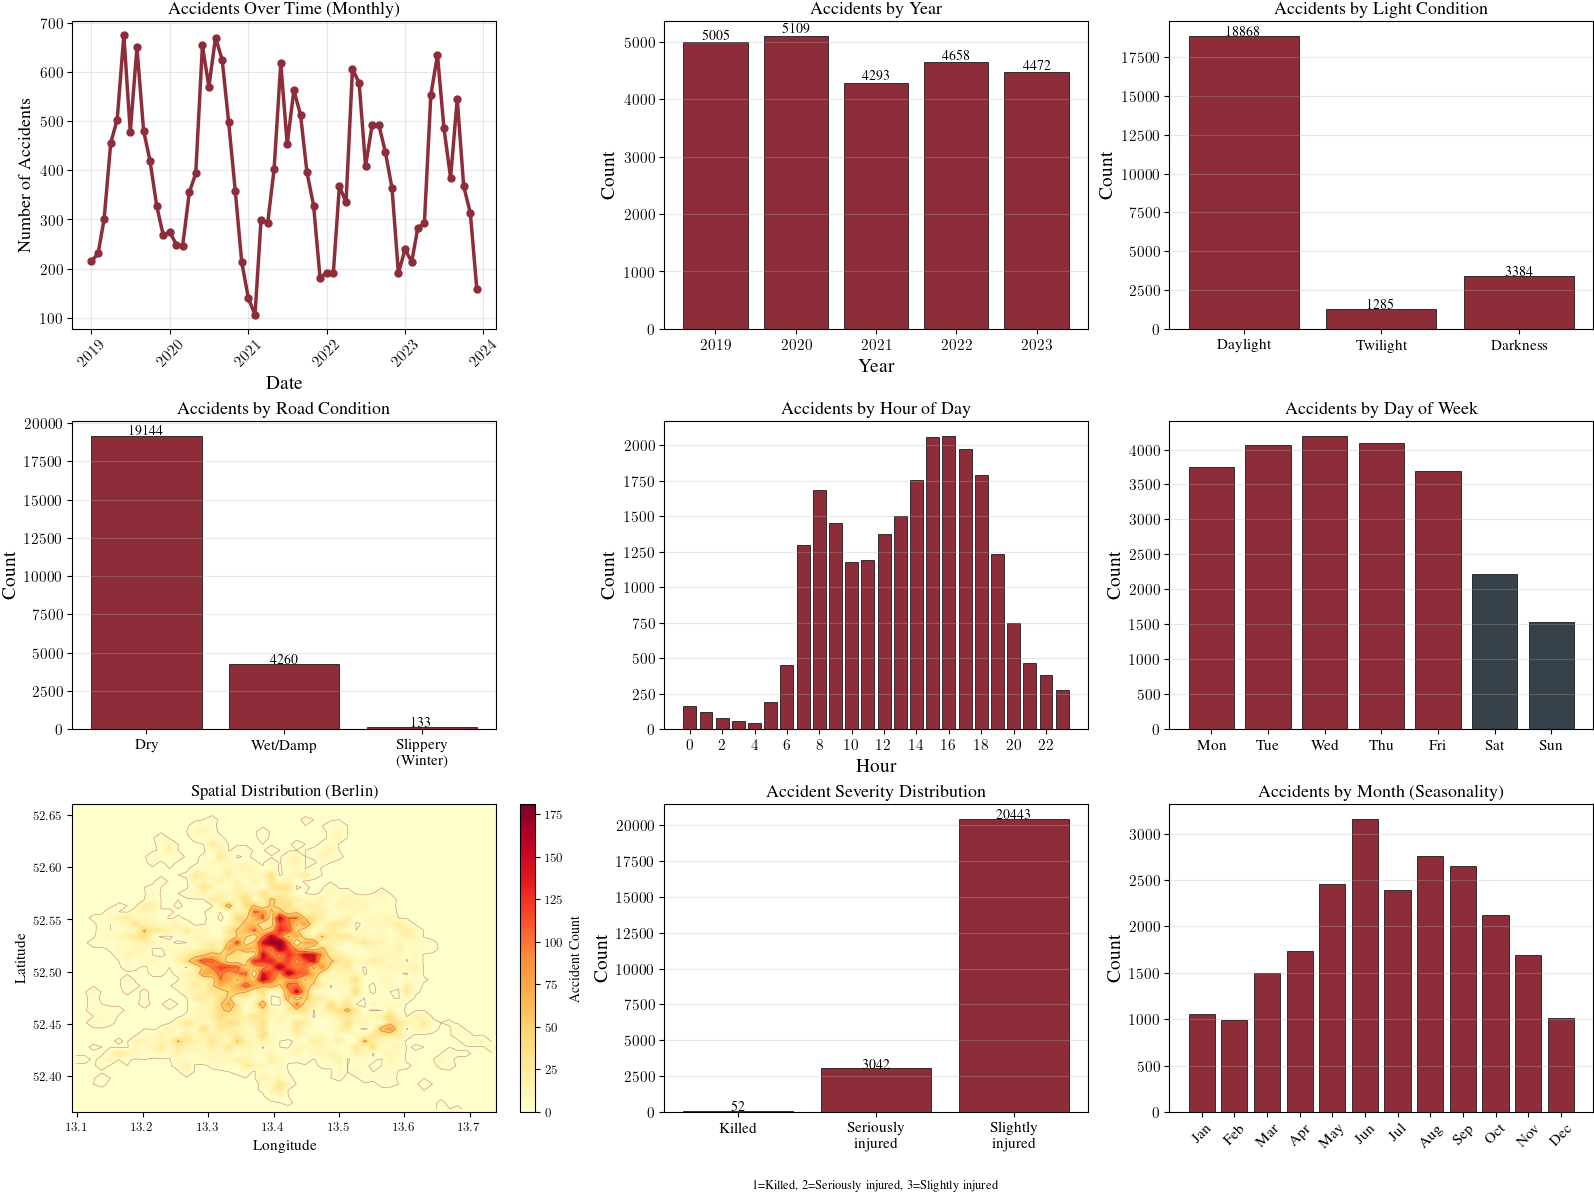


============================SUMMARY STATISTICS============================
Total accidents: 23,537
Date range: 2019 - 2023
Number of columns: 30
[PASS] Duplicate check (accident_id_extended)
  - Total non-null records: 18,532
  - Unique IDs: 18,532
  - Duplicates: 0
  - Missing IDs (NaN): 5,005

Duplicate check by accident characteristics:
  [FAIL] Duplicates by all characteristics: 4
  [FAIL] Duplicates among NULL accident_id_extended records: 2

Missing unique key (accident_id_extended) by year:
  Year | Missing Keys | Total Records | % Missing
  ---------------------------------------------
  2019 |        5,005 |         5,005 |  100.00%
  2020 |            0 |         5,109 |    0.00%
  2021 |            0 |         4,293 |    0.00%
  2022 |            0 |         4,658 |    0.00%
  2023 |            0 |         4,472 |    0.00%
  ---------------------------------------------
  TOTAL |        5,005 |        23,537 |   21.26%

[PASS] Temporal validity check (2019-2023)

Missing va

In [ ]:
plot_accident_quality_overview(
    accidents_bike_berlin, 
    use_tueplots=True,
    save_path=None  # Set to "accident_overview_icml.pdf" to save
)

**Data Quality Summary**

After filtering to Berlin bicycle accidents in our dataset:
- **Final dataset size**: 23,537 records (1.9% of original raw dataset)
- **Temporal coverage**: Consistent across 2019-2023
- **Duplicate records**: ~1% by accident characteristics → to be removed
- **Missing `accident_id_extended`**: 21.2% of records, but only from 2019 (field not collected that year)
- **Other fields**: No quality issues detected

**Conclusion**: Dataset is ready for spatial and temporal analysis.

In [22]:
duplicate_cols = [col for col in [
    'year', 'month', 'weekday', 'hour', 'XGCSWGS84', 'YGCSWGS84',
    'injury_severity', 'accident_kind', 'accident_type',
    'light_condition', 'road_condition_flag',
    'involved_bicycle', 'involved_passenger_car', 'involved_pedestrian',
    'involved_motorcycle', 'involved_goods_vehicle', 'involved_other_vehicle',
] if col in accidents_bike_berlin.columns]

n_before = len(accidents_bike_berlin)
accidents_bike_berlin = accidents_bike_berlin.drop_duplicates(subset=duplicate_cols, keep='first')
n_removed = n_before - len(accidents_bike_berlin)

print(f"Duplicate removal: {n_before:,} → {len(accidents_bike_berlin):,} records (-{100*n_removed/n_before:.2f}%)")

save_panel(accidents_bike_berlin, "berlin_bike_accidents.parquet", format='csv')

Duplicate removal: 23,537 → 23,535 records (-0.01%)
Saved: /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_bike_accidents.csv


PosixPath('/Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_bike_accidents.csv')

## Road Network Geometry

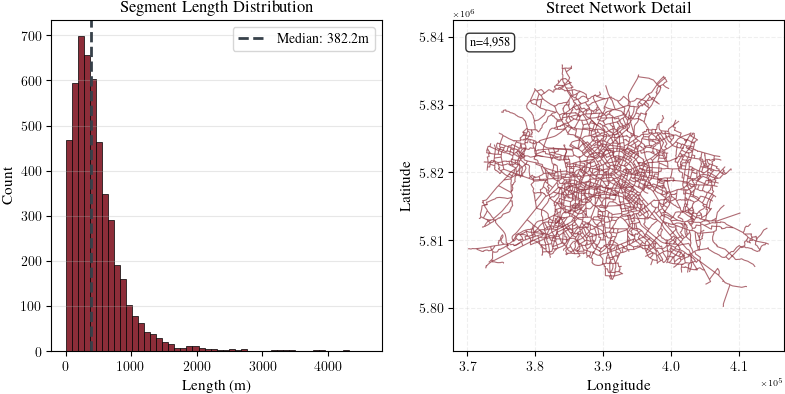


============================SUMMARY STATISTICS============================
Total segments: 4,958
Number of columns: 4

[PASS] Valid Geometry
  Description: All geometries are valid (invalid: 0)

[PASS] No Empty Geometry
  Description: No empty geometries (empty: 0)

[PASS] Coordinate Range (Berlin)
  Description: Coordinates within Berlin bounds (lat: 52.3-52.7, lon: 13.0-13.8)

[PASS] Unique Segment IDs
  Description: All segment IDs are unique (total: 4958, unique: 4958)

[PASS] Reasonable Lengths (1-5000m)
  Description: All lengths in valid range (too short: 0, too long: 0)

No missing values detected!


In [ ]:
segment_geo_gdf = segments_geometry_raw.segments_gdf
segment_static = segments_geometry_raw.segment_static

plot_segment_quality_overview(segment_geo_gdf, use_tueplots=True)

**Segment Geometry Quality Assessment**

Road network segment data validation completed:
- **Geometry validity**: All geometries valid and complete
- **Segment lengths**: Within reasonable bounds (1–5000 m)
- **Coordinate coverage**: Verified for Berlin area (52.3–52.7°N, 13.0–13.8°E)
- **Duplicate segment IDs**: None detected
- **Data completeness**: No missing coordinate values

**Conclusion**: Geometry data ready for spatial joins and analysis.

## Strava Exposure Data

/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/strava_exposure.py:435: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.4, wspace=0.35)


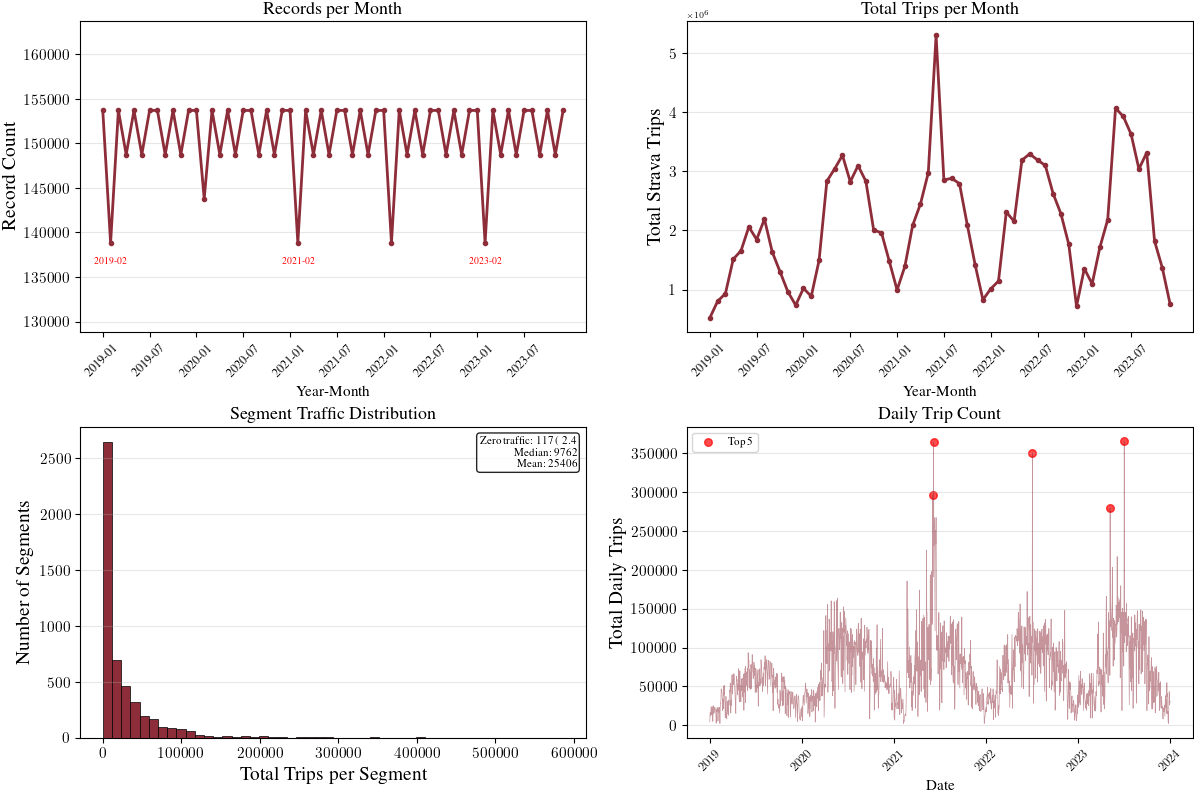


===================== SUMMARY STATISTICS =====================
Total records: 9,053,308
Number of columns: 137

Data Quality Checks:
[PASS] Temporal Coverage (2019-2023) - Date range: 2019-2023 (expected: 2019-2023)
[PASS] No Duplicate Records (segment+date) - Unique records by segment+date
[PASS] Non-negative Trip Counts - All trip counts non-negative
[FAIL] No Segments with Zero Traffic - Zero traffic found in 117 segments (2.4%)
[PASS] Segment Coverage Consistency - 4,958 unique segments, avg 1826 records/segment
[PASS] Temporal Coverage - 2019-01-01 to 2023-12-31, 0 missing days (0.0% of 1826)
[PASS] Key Columns (Geo Validated) - All columns complete

Unique segments: 4,958
  - Segments with zero trips: 117
  - Segment traffic median: 9762
  - Segment traffic max: 586505

Temporal coverage:
  - Total days in range: 1826
  - Days with data: 1826
  - Missing days (gaps): 0 (0.0%)

Trip count statistics:
  - Mean: 13.9
  - Median: 5.0
  - Min: 0.0
  - Max: 4370.0
  - Total trips: 125

In [ ]:
plot_strava_quality_overview(strava_berlin_data_raw, use_tueplots=True)

In [28]:
outlier_days_df = get_daily_outlier_days(strava_berlin_data_raw)
outlier_days_df.head()

,Date,Day of Week,Trip Count,Type
0,2023-07-02,Sunday,365380,High
1,2021-06-06,Sunday,364540,High
2,2022-07-03,Sunday,349880,High
3,2021-06-03,Thursday,296200,High
4,2023-05-07,Sunday,279560,High


Let's check events on top-5 days with high traffic in Berlin:
1. [On July 2, 2023](https://www.tagesspiegel.de/berlin/radwegestopp-nicht-mit-uns-8000-radfahrer-nehmen-an-demonstration-gegen-berliner-verkehrspolitik-teil-10078069.html), thousands of cyclists protested in Berlin against the Senate's decision to halt the expansion of new bike lanes, marching toward the Red City Hall - 
2. On June 6, 2021, the main bicycle-related events in Berlin included a large city-wide demonstration and elite-level competition.
3. [On July 3, 2022](https://www.morgenpost.de/berlin/article401495850/velocity-rennen-strassensperrungen-wegen-radsport-event.html), Berlin hosted the inaugural VeloCity Berlin bicycle race. 
4. On June 3, 2021, which coincided with World Bicycle Day.
5. On May 7, 2023, the primary bicycling event in Berlin was the VELOBerlin bike festival.

**Strava Exposure Data Quality Assessment**

Validation results:
- **Temporal coverage**: 2019-01-01 to 2023-12-31 with no gaps (1,826 days complete). Note: February months show fewer records due to fewer calendar days (28/29 vs 30/31) → **[PASS]** expected behavior
- **Segments**: 4,958 unique segments; **117 segments with zero traffic (2.4%) → [FAIL]** require filtering
- **Traffic peaks**: Align with cycling events (July 2023 protest, June 2021 demonstrations, VeloCity race, etc.) → **[PASS]**
- **Data quality**: 7/8 checks passed; no negative values; all required columns present

**Conclusion**: Need to filter zero-traffic segments before aggregation to ensure valid exposure variation for modeling.

### Feature Stability Analysis

Computes which columns are constant per segment (varying == 0) for use in downstream aggregation. The aggregation function `build_exposure_panel_segment_year_month()` applies hardcoded strategy:
- **Sum aggregation**: Trip counts (total, ride, e-bike, commute, leisure, by time/demographics), vehicle counts (motorized proxy)
- **Mean aggregation**: Speed metrics
- **Constant features**: Infrastructure (road type, lanes, speed limits) and connectivity (degree, betweenness)

In [29]:
# Compute which columns are constant per segment (for aggregation strategy)
summary_df = column_stability_summary(strava_berlin_data_raw, group_col="counter_name")
# This identifies constant columns (segments_varying == 0) that will be preserved during aggregation

# Datasets aggregation and merging

### Spatial Join: Accidents to Road Segments

Assigns each bicycle accident to its nearest road network segment using `assign_accidents_to_nearest_segment()`.

**Method:**
- Uses `gpd.sjoin_nearest()` with `max_distance_m=10` meters
- Accidents beyond this threshold remain unassigned
- When multiple segments are equidistant, keeps the first one after sorting by distance
- Ensures each accident is assigned to exactly one segment (duplicates removed by `acc_id`)

In [31]:
# Assign each accident to exactly one nearest segment (within max_distance)
joined_nearest_unique = assign_accidents_to_nearest_segment(
    accidents_bike_berlin,
    segment_geo_gdf,
    canonical_crs=CANONICAL_CRS,
    max_distance_m=MAX_DISTANCE_M,
)

# Spatial join validation
coverage = len(joined_nearest_unique) / len(accidents_bike_berlin)
print(f"SPATIAL JOIN:")
print(f"Total accidents: {len(accidents_bike_berlin):,}")
print(f"Assigned accidents: {len(joined_nearest_unique):,} ({coverage:.1%}) [{'PASS' if coverage >= 0.90 else 'WARN'}]")
print(f"Matched segments: {joined_nearest_unique['counter_name'].nunique():,} / {len(segment_geo_gdf):,},\
({joined_nearest_unique['counter_name'].nunique() / len(segment_geo_gdf):.2%})")

SPATIAL JOIN:
Total accidents: 23,535
Assigned accidents: 15,396 (65.4%) [WARN]
Matched segments: 3,286 / 4,958,(66.28%)


### Strava bicycle traffic volume aggregation (segments–year–month)

Converts daily Strava traffic volumes into a segment × year × month panel for risk analysis.

**Aggregation strategy** (hardcoded in `build_exposure_panel_segment_year_month()`):
- **Sum aggregation**: Trip counts (total, ride, commute, leisure, by time of day), people counts (by demographics), vehicle counts (motorized traffic proxy)
- **Mean aggregation**: Speed metrics (average speed per segment per month)
- **Constant features**: Infrastructure attributes (road type, lanes, speed limits), connectivity metrics (degree, betweenness) — stored once per segment

**Why**: Align with accident data temporal granularity (segment–month level) and enable direct exposure-outcome comparisons.  

In [32]:
strava_berlin_data_agg_rich = build_exposure_panel_segment_year_month(
    strava_berlin_data_raw,
    segment_static=segment_static,
    summary_df=summary_df,
)

Before merging exposure and accident panels, we need to understand the effect of 0 traffic volume for segments. 


In [33]:
filter_impact = compute_segment_filter_impact(strava_berlin_data_agg_rich)
display(filter_impact.round(1))

,Filter Criterion,Segments Remaining,Segments Lost,Loss %
0,Remove segments with 0 traffic (all time),4841,117,2.4
1,Remove segments with 0 traffic in any year,4335,623,12.6
2,Remove segments with 0 traffic in any month,2698,2260,45.6


**Why filter zero-traffic years?**

Including segments with any zero-traffic year confounds true exposure variation with data collection gaps. We cannot distinguish whether zero traffic reflects:
- Actual segment inactivity (unmaintained street)
- Monitoring discontinuity (sensor malfunction)
- Deployment timing (segment added mid-study)

So, we keep only segments with positive traffic in all 5 years (2019–2023). Such removal enable us to keep 87,4% of segments.

In [34]:
# Apply filtering: remove segments with zero traffic in any year
strava_berlin_data_agg_reach_clean = filter_zero_traffic_years(strava_berlin_data_agg_rich)

# Loss metrics
baseline = strava_berlin_data_agg_rich['counter_name'].nunique()
filtered = strava_berlin_data_agg_reach_clean['counter_name'].nunique()
pct_loss = (1 - filtered / baseline) * 100

print(f"Segments: {baseline:,} → {filtered:,} (-{pct_loss:.1f}%)")
print(f"Records: {strava_berlin_data_agg_rich.shape[0]:,} → {strava_berlin_data_agg_reach_clean.shape[0]:,}")

Removed 623 segments with zero traffic in any year
Segments remaining: 4,335 (from 4,958)
Segments: 4,958 → 4,335 (-12.6%)
Records: 297,480 → 260,100


### Accidents aggregation (segment–year–month)

Aggregates Unfallatlas accidents assigned to segments into a segment × year × month accident panel.

In [35]:
min_year = int(strava_berlin_data_agg_rich["year"].min())
max_year = int(strava_berlin_data_agg_rich["year"].max())

# accidents_agg_ym_rich
accidents_agg_rich = aggregate_accidents_segment_year_month_rich(
    joined_nearest_unique,
    column_map=ACCIDENT_COLUMNS_EN,
    exposure_year_min=min_year,
    exposure_year_max=max_year,
)

print("Rich accident aggregate (segment–year–month) shape:", accidents_agg_rich.shape)

Rich accident aggregate (segment–year–month) shape: (14084, 74)


### Merge Strategy: LEFT JOIN

Keep all cleaned exposure records and match accidents where they exist. This ensures complete coverage of valid traffic data while allowing zero-accident months (informative for risk modeling).

In [ ]:
merge_keys = ["counter_name", "year", "month"]

# Left join: keep all exposure records, attach accidents where they exist
merged_accidents_strava = merge_exposure_and_accidents(
    strava_berlin_data_agg_reach_clean,
    accidents_agg_rich,
    merge_keys=merge_keys,
    trip_col="sum_strava_total_trip_count",
    how='left'
)

# Validation
print(f"Columns in joined datasets: {strava_berlin_data_agg_reach_clean.shape[1]:,} + {accidents_agg_rich.shape[1]:,} - {len(merge_keys):,} (keys) = {strava_berlin_data_agg_reach_clean.shape[1] + accidents_agg_rich.shape[1] - len(merge_keys):,} expected")
print(f"Merged panel: {merged_accidents_strava.shape[0]:,} records, {merged_accidents_strava.shape[1]:,} columns (1 column for flag exposure_row_missing)")
print(f"  Segments: {merged_accidents_strava['counter_name'].nunique():,}")
print(f"  With accidents: {merged_accidents_strava['total_accidents'].notna().sum():,} ({100*merged_accidents_strava['total_accidents'].notna().sum()/len(merged_accidents_strava):.1f}%)")
print(f"  Missing trip data: {merged_accidents_strava['sum_strava_total_trip_count'].isna().sum():,} [should be 0]")

# Save merged segment panel
save_panel(
    merged_accidents_strava,
    "berlin_bike_accident_strava_panel.parquet",
    crs=segment_geo_gdf.crs,
    format='parquet'
)

Columns in joined datasets: 132 + 74 - 3 (keys) = 203 expected
Merged panel: 260,100 records, 204 columns (1 column for flag exposure_row_missing)
  Segments: 4,335
  With accidents: 260,100 (100.0%)
  Missing trip data: 0 [should be 0]
Saved: /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_bike_accident_strava_panel.parquet


PosixPath('/Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_bike_accident_strava_panel.parquet')

### Merged Panel: Quality Checks


/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/panels.py:487: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  


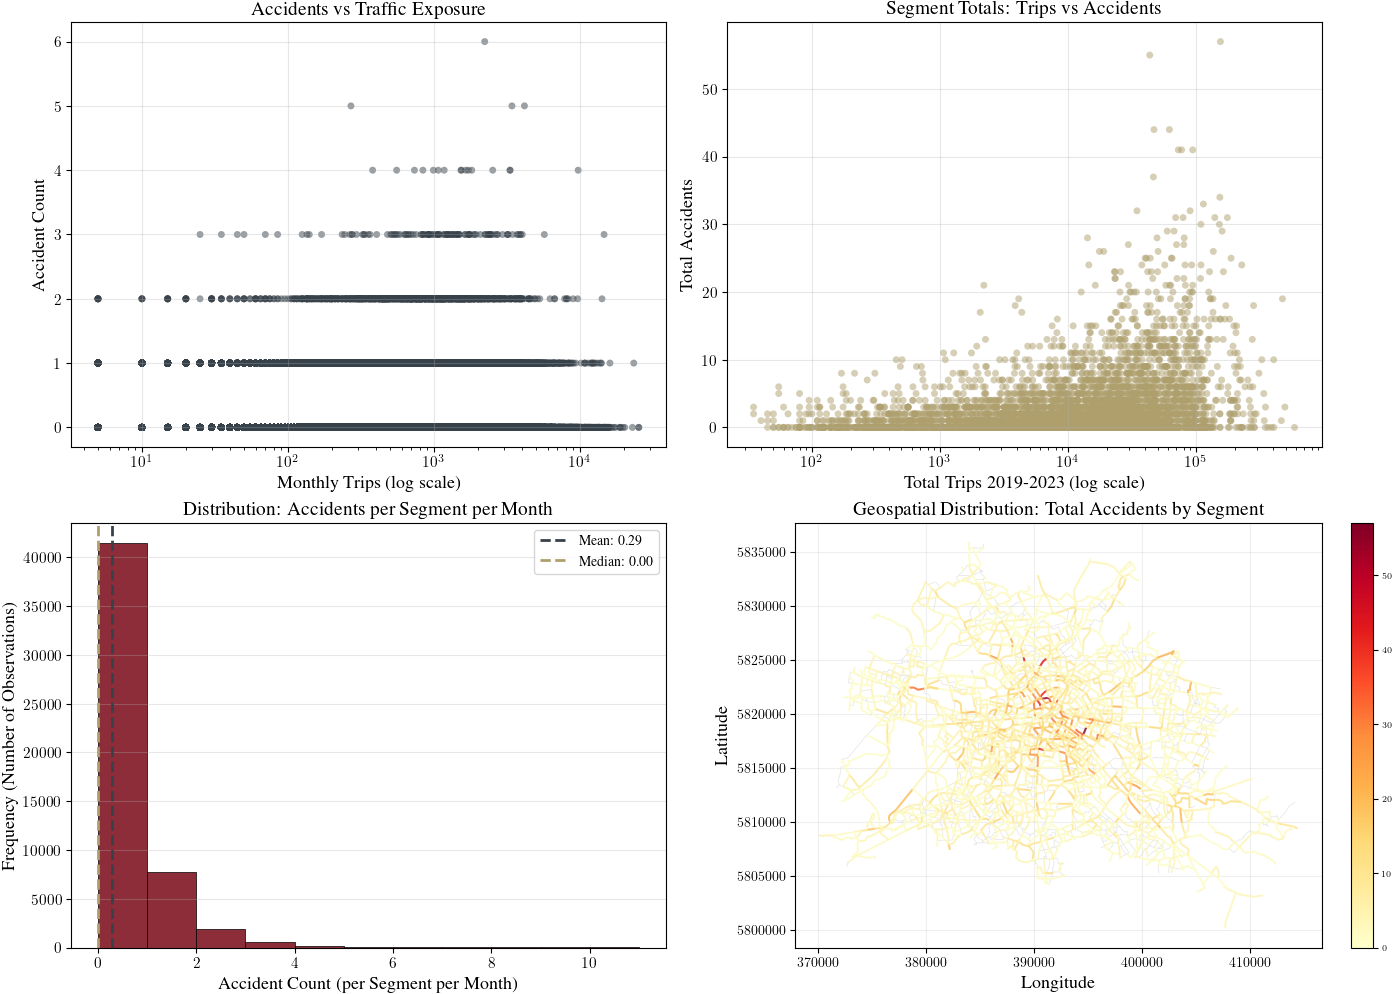

/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/panels.py:547: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  # 2. Merge completeness: all trip columns populated



============================SUMMARY STATISTICS============================

[PASS] temporal_consistency
   4335/4335 segments have complete temporal data
   Value: 100.0%

[FAIL] no_negative_values
   Found negative values in: mean_weather_temp_min, mean_socioeconomic_net_migration_per_100
   Value: Multiple

[WARN] plausibility_accidents_vs_trips
   347 rows (0.13%) have more accidents than trips
   Value: 0.13%


In [ ]:
fig, axes = plot_merged_panel_quality_overview(
    merged_accidents_strava,
    segment_geometry=segment_geo_gdf,  # Pass segment geometry for map visualization
    trip_col="sum_strava_total_trip_count",
    accident_col="total_accidents",
    figsize=(14, 10),
    use_tueplots=True,
)
plt.show()


In [63]:
# Filter implausible rows where accidents > trips
implausible_mask = (
    merged_accidents_strava['total_accidents'].notna() & 
    (merged_accidents_strava['total_accidents'] > merged_accidents_strava['sum_strava_total_trip_count'])
)
n_before_filter = len(merged_accidents_strava)
merged_accidents_strava = merged_accidents_strava[~implausible_mask].copy()
print(f"Filtered {n_before_filter - len(merged_accidents_strava):,} implausible rows (accidents > trips)")
print(f"Final panel: {len(merged_accidents_strava):,} records")

Filtered 347 implausible rows (accidents > trips)
Final panel: 259,753 records


## Build Nodes (Junctions) from Segment Endpoints

Converts road network segments into junction nodes using a two-stage process:

**Stage 1: Extract Raw Endpoints**
- Each road segment has two endpoints (start/end coordinates)
- Extract all unique endpoints as candidate junction points

**Stage 2: Cluster Nearby Endpoints (Snap Grid)**
- Group endpoints within `NODE_SNAP_TOLERANCE_M = 2` meters of each other
- Merge clustered endpoints into single representative nodes
- Eliminates duplicate junctions caused by coordinate precision or segment discretization

**Output:** Clean junction network properly mapped to the original segment topology

In [46]:
# Build raw nodes from segment endpoints
nodes_raw = build_nodes_from_segment_endpoints(
    segment_geo_gdf,
    counter_col="counter_name",
)

print(f"Raw nodes (all endpoints): {len(nodes_raw):,}")

# Cluster nearby endpoints into unified nodes (snap grid tolerance = 2m)
clustering = cluster_nodes_snap_grid(
    nodes_raw,
    tol_m=NODE_SNAP_TOLERANCE_M,
    counter_col="counter_name",
)

nodes_raw = clustering.nodes_raw
node_points = clustering.node_points
segment_node_map = clustering.segment_node_map

print(f"Clustered nodes (after snapping): {len(node_points):,}")
print(f"Reduction: {len(nodes_raw):,} → {len(node_points):,} ({(1 - len(node_points)/len(nodes_raw))*100:.1f}% merged)")

Raw nodes (all endpoints): 9,916
Clustered nodes (after snapping): 3,155
Reduction: 9,916 → 3,155 (68.2% merged)


### Define Crossings (Intersections)

Select junction nodes that are actual intersections (degree ≥ 3):
- **Degree 1-2**: Endpoints or inline nodes (not intersections)
- **Degree ≥ 3**: True intersections where multiple segments meet

These crossing nodes become the focus for accident analysis.

In [47]:
# Select crossing nodes (degree >= 3)
crossing_ids = select_crossings_by_degree(
    nodes_raw,
    min_degree=CROSSING_MIN_DEGREE,
    counter_col="counter_name",
)

# Filter to only crossing nodes
crossings_gdf = node_points[node_points["node_id"].isin(crossing_ids)].copy()

print(f"Total nodes: {len(node_points):,}")
print(f"Crossing nodes (degree >= {CROSSING_MIN_DEGREE}): {len(crossings_gdf):,}")
print(f"Crossings represent {(len(crossings_gdf) / len(node_points) * 100):.1f}% of all nodes")

Total nodes: 3,155
Crossing nodes (degree >= 3): 2,924
Crossings represent 92.7% of all nodes


### Assign Accidents to Nearest Crossing

Spatial join between accidents and crossing nodes:
- Match each accident to its nearest crossing within `MAX_DISTANCE_M_NEREAST_CROSSING = 20` meters
- Preserve all accident factors (injury severity, type, time of day, etc.) for aggregation
- Build crossing-level accident panel (accidents × crossings × year × month)

In [ ]:
# Select columns to preserve for accident factor analysis
factor_cols = ["acc_id", "year", "month", "geometry"]

# Add categorical factors if they exist
factor_cols_optional = [
    "weekday_type", "time_of_day", "light_condition", "road_condition",
    "accident_type", "accident_kind", "injury_severity"
]
for col in factor_cols_optional:
    if col in joined_nearest_unique.columns:
        factor_cols.append(col)

study_area_accidents = joined_nearest_unique[factor_cols].copy()

# Assign each accident to nearest crossing (within 20m)
acc_node, acc_node_ym = assign_accidents_to_nearest_crossing(
    study_area_accidents,
    crossings_gdf,
    max_distance_m=MAX_DISTANCE_M_NEREAST_CROSSING,
)

# Report assignment results
total_accidents = len(acc_node)
assigned_accidents = int(acc_node["has_crossing"].sum())
unassigned_accidents = total_accidents - assigned_accidents
assignment_rate = (assigned_accidents / total_accidents * 100) if total_accidents > 0 else 0

print(f"\nACCIDENT-TO-CROSSING ASSIGNMENT:")
print(f"Total accidents (in study area): {total_accidents:,}")
print(f"Assigned to crossings: {assigned_accidents:,} ({assignment_rate:.1f}%)")
print(f"\nAccident groups (crossing × year × month): {len(acc_node_ym):,} records")

# Save results
save_panel(acc_node, "acc_node.parquet", format='parquet')


ACCIDENT-TO-CROSSING ASSIGNMENT:
Total accidents (in study area): 15,396
Assigned to crossings: 4,844 (31.5%)

Accident groups (crossing × year × month): 4,597 records
Saved: /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/acc_node.csv


PosixPath('/Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/acc_node.csv')

In [65]:
acc_node_ym

,node_id,year,month,total_accidents,acc_injury_severity_count_1,acc_injury_severity_count_2,acc_injury_severity_count_3,acc_injury_severity_share_1,acc_injury_severity_share_2,acc_injury_severity_share_3,...,acc_weekday_type_count_weekday,acc_weekday_type_count_weekend,acc_weekday_type_share_weekday,acc_weekday_type_share_weekend,acc_time_of_day_count_evening (18h-22h),acc_time_of_day_count_night (22h-7h),acc_time_of_day_count_work_hours (7h-18h),acc_time_of_day_share_evening (18h-22h),acc_time_of_day_share_night (22h-7h),acc_time_of_day_share_work_hours (7h-18h)
0,0,2020,6,1,0,0,1,0.0,0.0,1.0,...,0,1,0.0,1.0,0,0,1,0.0,0.0,1.0
1,0,2020,9,1,0,0,1,0.0,0.0,1.0,...,1,0,1.0,0.0,0,0,1,0.0,0.0,1.0
2,0,2023,5,1,0,0,1,0.0,0.0,1.0,...,1,0,1.0,0.0,0,0,1,0.0,0.0,1.0
3,0,2023,6,2,0,1,1,0.0,0.5,0.5,...,1,1,0.5,0.5,0,0,2,0.0,0.0,1.0
4,1,2019,3,1,0,0,1,0.0,0.0,1.0,...,0,1,0.0,1.0,0,0,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,3142,2020,8,2,0,0,2,0.0,0.0,1.0,...,1,1,0.5,0.5,1,0,1,0.5,0.0,0.5
4593,3142,2020,10,1,0,1,0,0.0,1.0,0.0,...,1,0,1.0,0.0,0,1,0,0.0,1.0,0.0
4594,3142,2021,7,1,0,0,1,0.0,0.0,1.0,...,1,0,1.0,0.0,0,1,0,0.0,1.0,0.0
4595,3142,2023,5,1,0,0,1,0.0,0.0,1.0,...,1,0,1.0,0.0,0,0,1,0.0,0.0,1.0


### Build Node-Level Exposure from Segment Flows

Converts segment × year × month exposure data into crossing (node) × year × month format by aggregating segment traffic.

**Important:** This aggregation is performed **only for crossing nodes** (junctions with degree ≥ 3), not for all nodes.

**Method:** 
- For each crossing node, find all segments connected to that node (via `segment_node_map`)
- Sum trip volumes across all connected segments for each crossing × year × month combination
- Eliminates duplicate segment-node pairs (when start/end collapse to same node)
- **Apply 0.5 correction factor** to account for double-counting: each segment contributes traffic to 2 nodes (start/end), so we multiply the summed exposure by 0.5 to avoid inflating node-level exposure

**Output:** Node-level exposure (corrected trips/month at each crossing), aggregated from all connected segments with double-counting adjustment applied.

In [ ]:
# Build node-level exposure panel (crossing × year × month)
crossing_exposure_ym = build_node_exposure_panel_from_segments(
    strava_berlin_data_agg_reach_clean,
    segment_node_map,
    crossing_ids,
    trip_col="sum_strava_total_trip_count",
)

# Quality checks on aggregated node exposure
print_node_exposure_quality_summary(
    crossing_exposure_ym,
    crossings_gdf,
    trip_col="monthly_strava_trips",
)

# Save node exposure panel
print(f"Saving node exposure panel...")
save_panel(crossing_exposure_ym, "berlin_bike_node_exposure_panel.parquet", format='csv')


====================NODE EXPOSURE QUALITY SUMMARY====================

[PASS] dataset_structure
   171,720 records (crossing × year × month combinations)
   Value: 2,862 unique crossings

[PASS] crossing_coverage
   2,862 / 2,924 crossings present in panel (62 crossings absent)
   Value: 97.9%

[PASS] temporal_coverage
   Years: 2019–2023, 60 / 60 expected year-month combinations
   Value: 60 months

[INFO] trip_volume_per_month
   Trips/month per crossing: Mean=723, Median=345, Std=1,118
   Value: Range: 0–26,628

[PASS] no_missing_values_in_records
   0 records with NaN trip values (among 171,720 existing records)
   Value: 0.00%

[INFO] zero_trip_records_per_month
   6,174 month-records with zero trips (out of 171,720 total records)
   Value: 3.60%

[PASS] zero_trip_crossings_all_time
   0 crossings with zero total trips across all years (2019-2023)
   Value: 0.00%
Saving node exposure panel...
Saved: /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_b

PosixPath('/Users/laysan/Desktop/University/data_literacy_/data_literacy/data/panel/berlin_bike_node_exposure_panel.csv')

**Node Exposure Panel: Final Data Summary**

**Panel structure:** 171,720 records for 2,862 crossings (2019–2023, 60 months) | **Coverage:** 97.9% (62 crossings missing)

**Missing crossings explanation:** All segments connected to these 62 crossings were filtered during preprocessing (zero-traffic years), so they have no exposure data.

**Data quality:** 
- 3.6% zero-trip month-records (seasonal/temporary closures)